This notebook shows how to apply Neural Networks to predict the global temperature, based on the time series of CO2 & CH4.

By Weiwei Zhan

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-09-20 17:24:55.374432: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-20 17:24:55.428529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

## Some visualization of the ClimateBench data

Before training ML models, let's plot the ClimateBench dataset for quick checking.

ClimateBench is a spatial-temporal dataset that contains simulations generated by the NorESM2 model. It provides both historical simulations & future projections under different scenarios (e.g., ssp245).

Four future scenarios are plotted here: `ssp126, ssp245, ssp370, ssp585`.

In [4]:
scenarios = ['historical','ssp126','ssp370','ssp585']
inputs = [os.path.join(train_path , f"inputs_{scenario}") for scenario in scenarios]
inputs.append(os.path.join(test_path, "inputs_ssp245"))
inputs.sort(key=lambda x:x.split('_')[-1])

outputs = [os.path.join(train_path , f"outputs_{scenario}") for scenario in scenarios]
outputs.append(os.path.join(test_path, "outputs_ssp245"))
outputs.sort(key=lambda x:x.split('_')[-1])


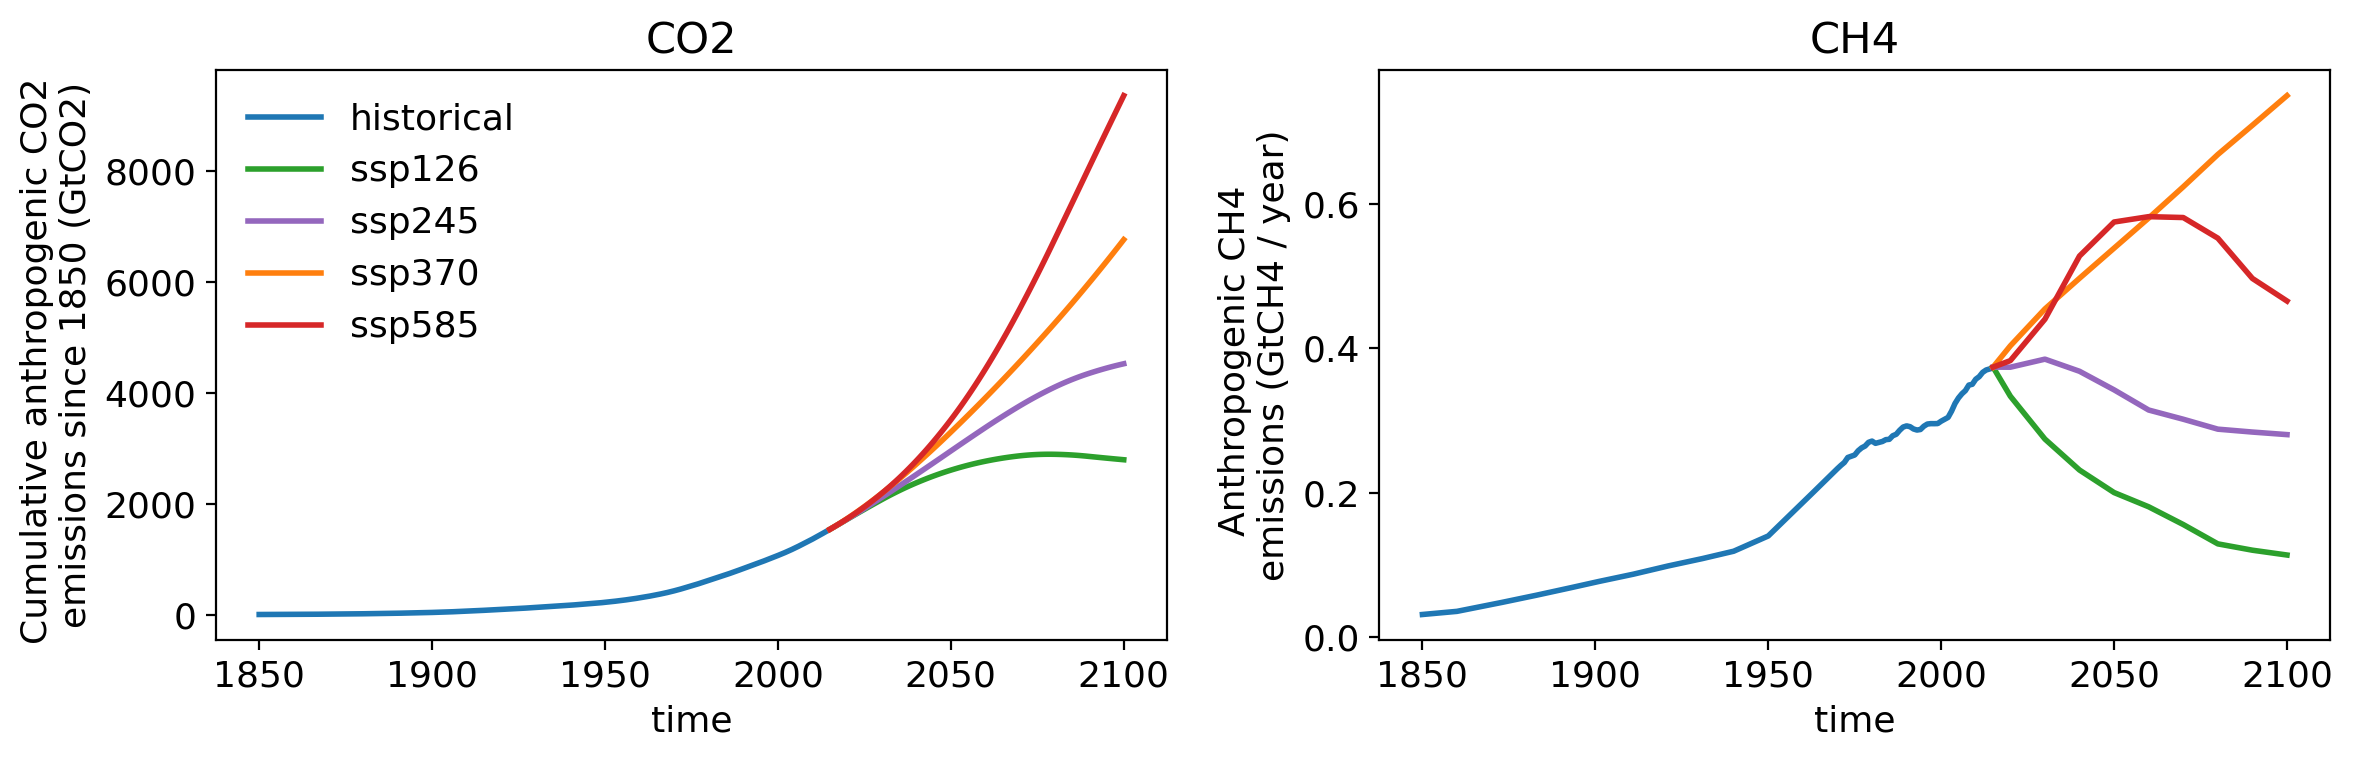

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
colors  = ['tab:blue','tab:green','tab:purple','tab:orange','tab:red']


for i,input in enumerate(inputs):

    label=input.split('_')[-1]#[:-3]
    X = open_dataset(input)
    x = X.time.data
    
    X['CO2'].plot(label=label,color=colors[i],linewidth=2,ax=axes[0])
    # axes[0].plot(x, X['CO2'].data, label=label,color=colors[i],linewidth=2)
    axes[0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    
    X['CH4'].plot(label=label,color=colors[i],linewidth=2,ax=axes[1])
    # axes[1].plot(x, X['CH4'].data, label=label,color=colors[i],linewidth=2)
    axes[1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    
axes[0].set_title('CO2')
axes[1].set_title('CH4')
axes[0].legend()
plt.tight_layout()

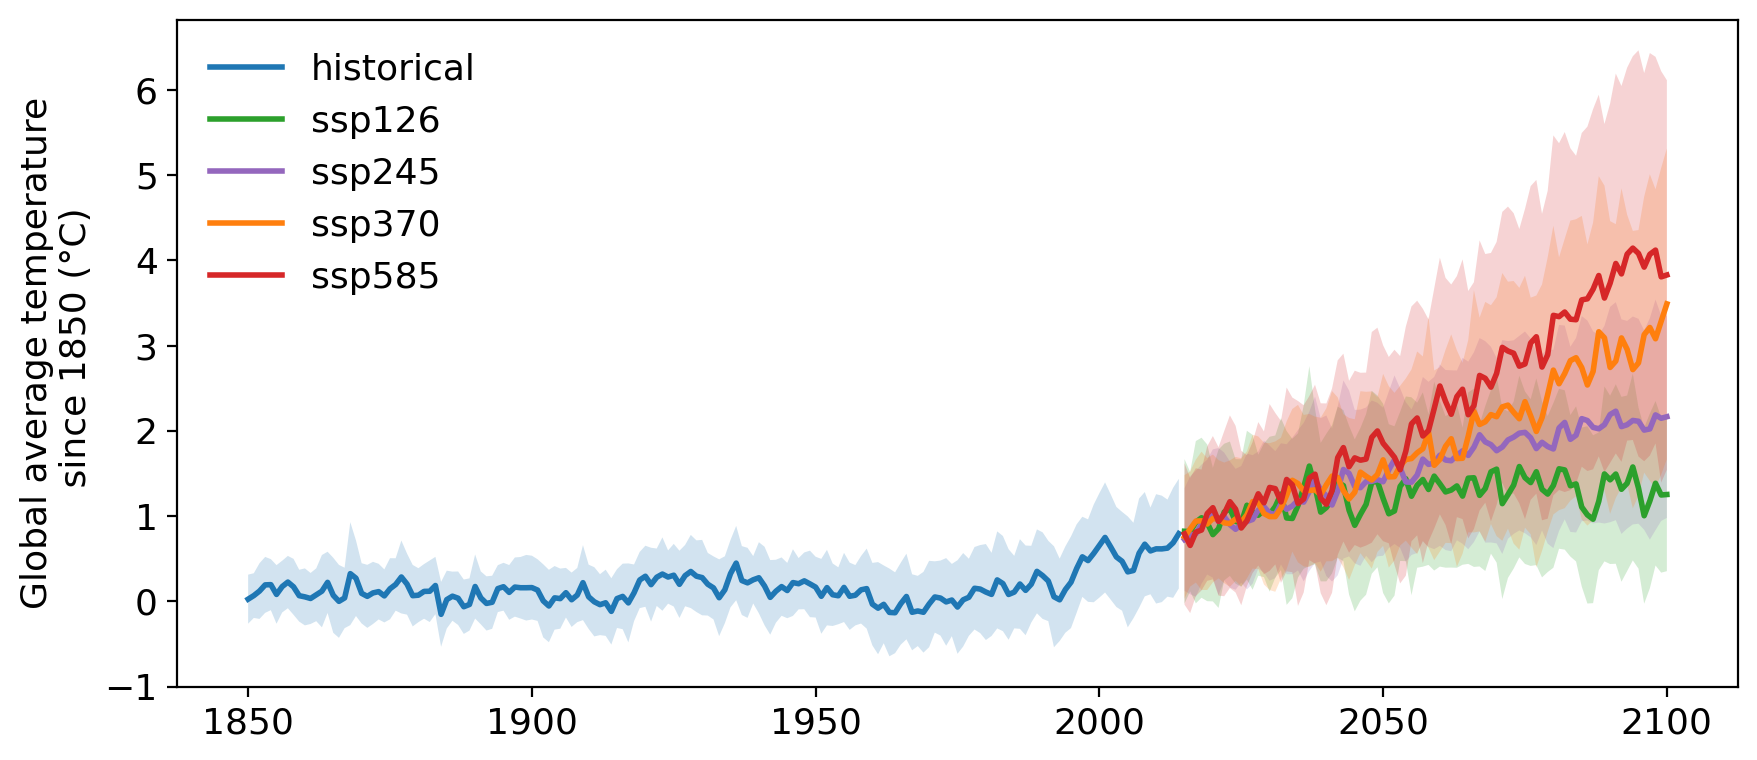

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(9,4))

for i,output in enumerate(outputs):

    label=output.split('_')[-1]#[:-3]
    X = open_dataset(output).mean(dim="member")[['tas']].drop(['quantile'])
    x = X.time.data
    
    weights  = np.cos(np.deg2rad(X.lat))
    tas_mean = X['tas'].weighted(weights).mean(['lat', 'lon']).data
    tas_std  = X['tas'].weighted(weights).std(['lat', 'lon']).data
    
    ax.plot(x, tas_mean, label=label,color=colors[i],linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=colors[i],alpha=0.2)
    
ax.set_ylabel("Global average temperature\n since 1850 (°C)")
ax.legend()
plt.tight_layout()


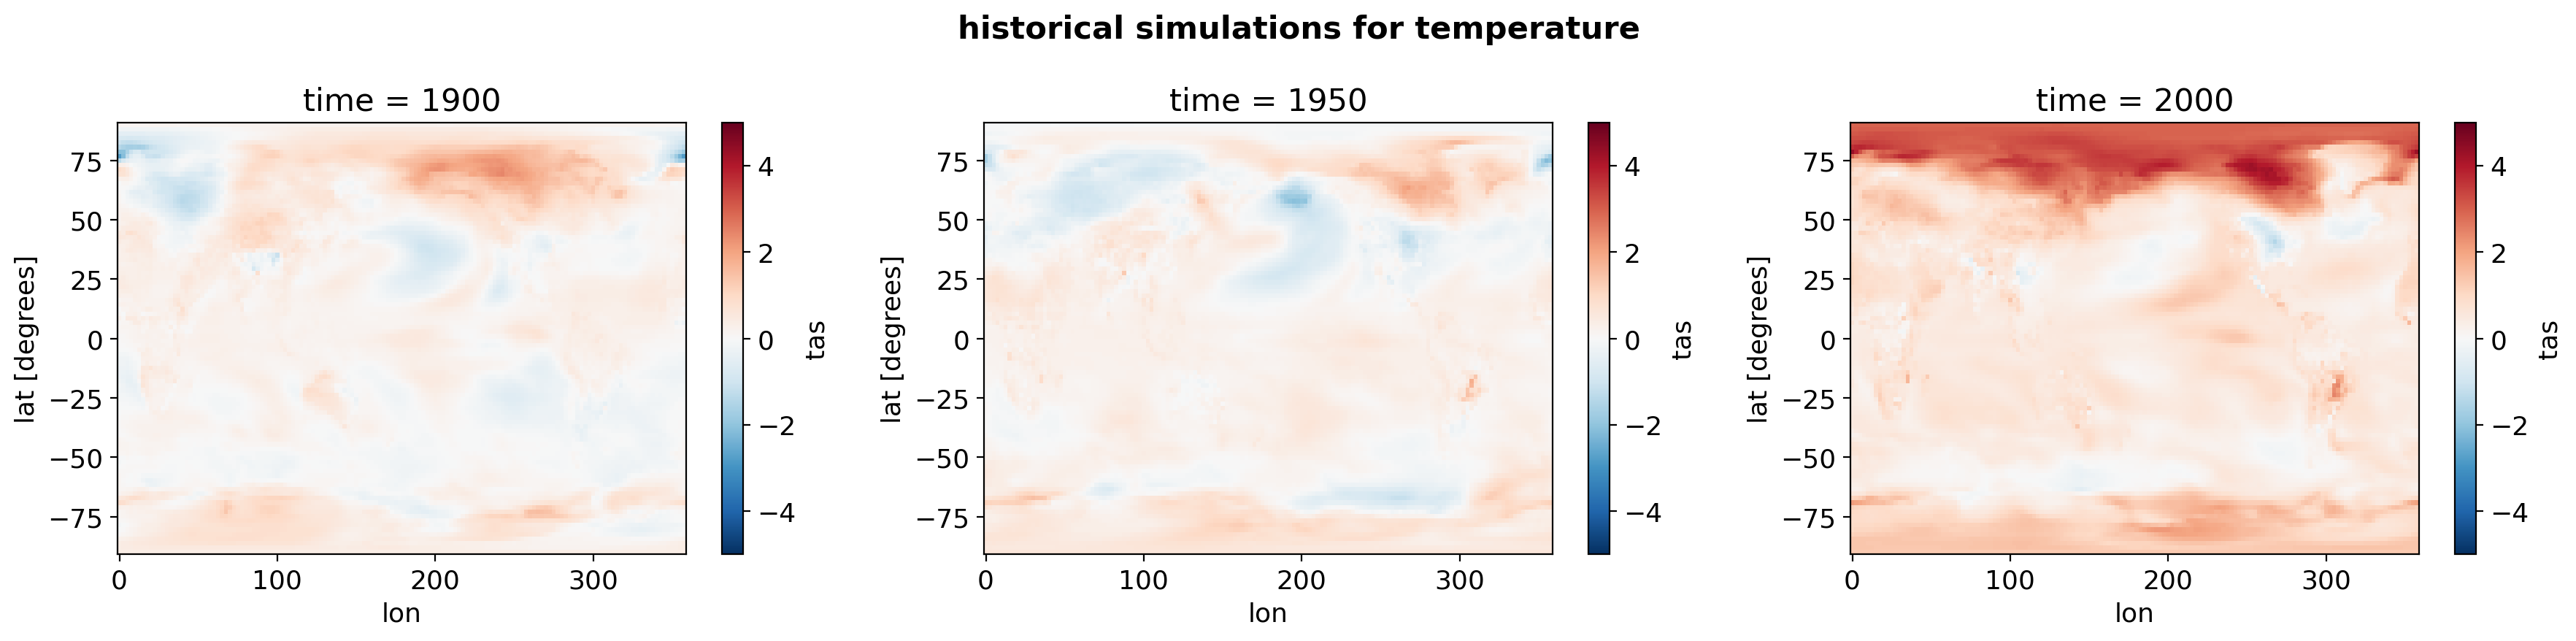

In [7]:
y_his    = open_dataset(os.path.join(train_path , "outputs_historical")).mean(dim="member")[['tas']].drop(['quantile'])
y_ssp370 = open_dataset(os.path.join(train_path,'outputs_ssp370')).mean(dim="member")[['tas']].drop(['quantile'])


fig,axes = plt.subplots(figsize=(18,4.5),ncols=3)
yr0, yr1, yr2 = 1900, 1950, 2000
vmin, vmax = -5, 5

y_his.sel(time=yr0).tas.plot(ax=axes.flat[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_his.sel(time=yr1).tas.plot(ax=axes.flat[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_his.sel(time=yr2).tas.plot(ax=axes.flat[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

fig.suptitle('historical simulations for temperature',fontweight='bold')
plt.tight_layout()

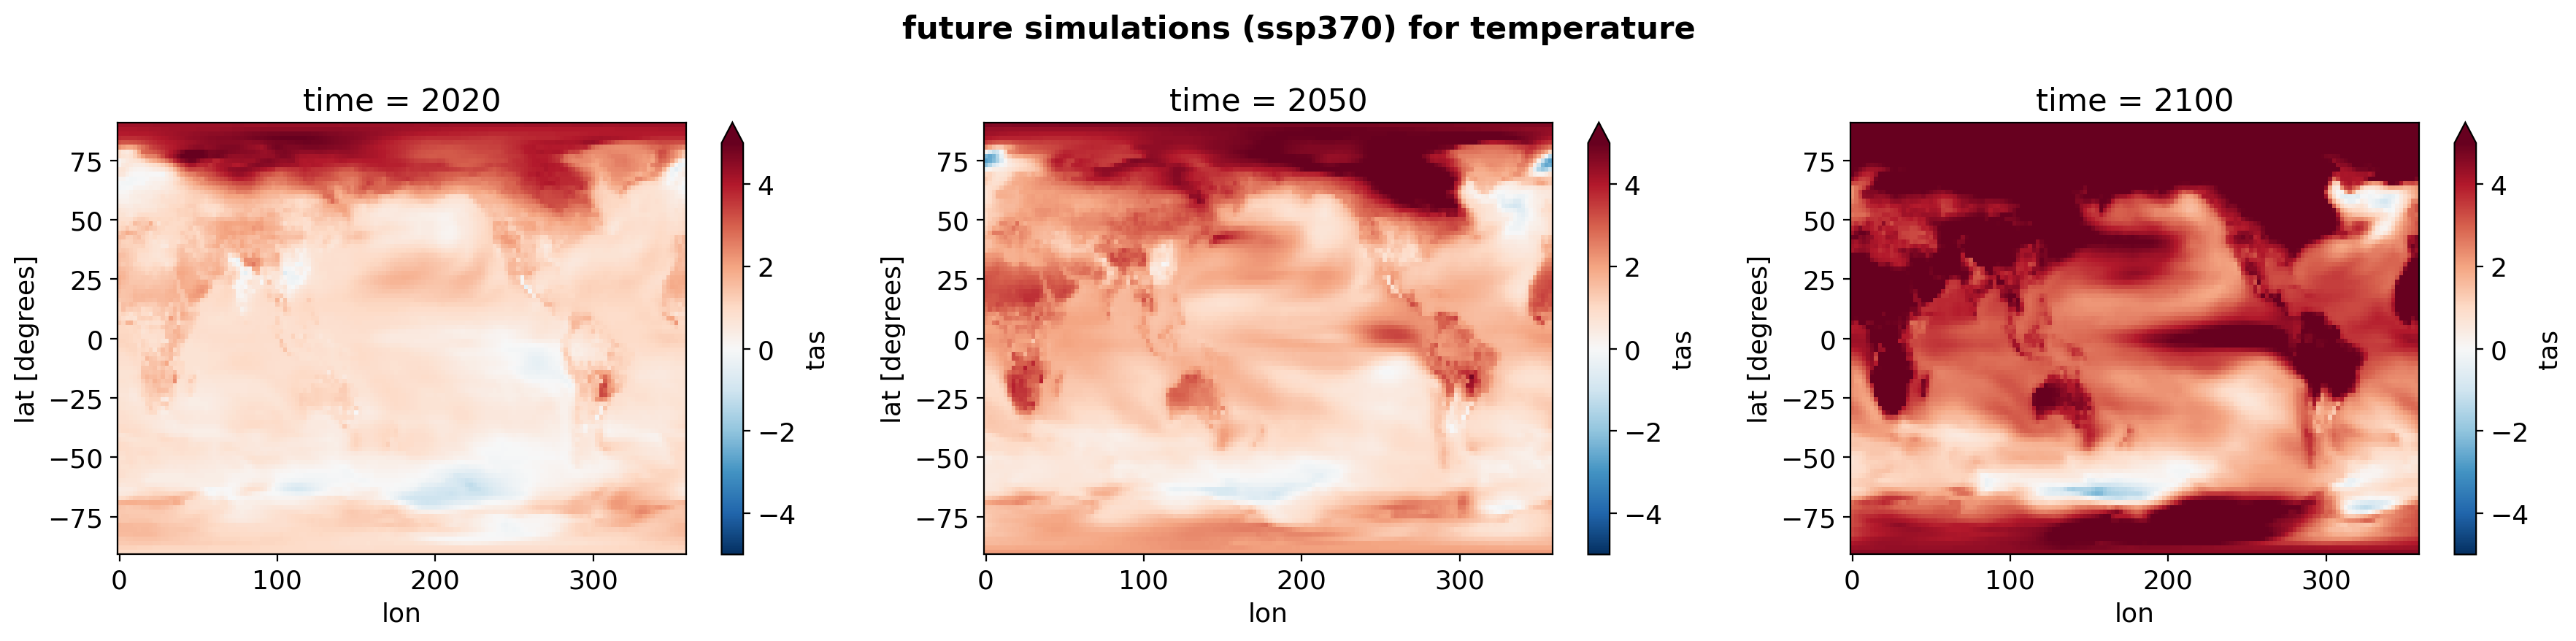

In [8]:
y_ssp370 = open_dataset(os.path.join(train_path,'outputs_ssp370')).mean(dim="member")[['tas']].drop(['quantile'])


fig,axes = plt.subplots(figsize=(18,4.5),ncols=3)
yr0, yr1, yr2 = 2020, 2050, 2100
vmin, vmax = -5, 5

y_ssp370.sel(time=yr0).tas.plot(ax=axes.flat[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_ssp370.sel(time=yr1).tas.plot(ax=axes.flat[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_ssp370.sel(time=yr2).tas.plot(ax=axes.flat[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

fig.suptitle('future simulations (ssp370) for temperature',fontweight='bold')
plt.tight_layout()

## Use Neural Networks (NN) for temperature prediction


Now, we are trying to use NN to predict the surface air temperature (tas), based on the time series of CO2 & CH4 emissions

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train NN using simulations from 3 historical and 3 future scenarios. <br/> Then we test the trained NN using the ssp245 scenario.

In [9]:
# Training set
train_files    = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [10]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

This is how our predictors & predictand data look like:

In [11]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


Note that here we stack the original 2-D tas data into a single dimension (for the purpose of NN implementation)

In [12]:
y_train_df.head()

latitude      -90.0                                                    \
longitude     0.0       2.5       5.0       7.5       10.0      12.5    
time                                                                    
0          0.320023  0.319946  0.319865  0.319885  0.319860  0.319865   
1         -0.667297 -0.667023 -0.667114 -0.667109 -0.667109 -0.667135   
2         -0.058345 -0.058167 -0.058248 -0.058243 -0.058248 -0.058248   
3          0.125870  0.125941  0.125946  0.125941  0.125946  0.125890   
4          0.418304  0.418533  0.418503  0.418523  0.418477  0.418513   

latitude                                           ...      90.0            \
longitude     15.0      17.5      20.0      22.5   ...     335.0     337.5   
time                                               ...                       
0          0.319870  0.319911  0.319763  0.319707  ...  0.913116  0.913289   
1         -0.667114 -0.667104 -0.667104 -0.666992  ...  0.042501  0.042679   
2         -0.058233 -0.058207 -0.058345 -0.058177  ...  1.167440  1.167389   
3          0.125951  0.125941  0.125895  0.125982  ... -0.339457 -0.339589   
4          0.418503  0.418549  0.418482  0.418564  ...  0.577006  0.576996   

latitude                                                               \
longitude     340.0     342.5     345.0     347.5     350.0     352.5   
time                                                                    
0          0.913116  0.912933  0.912893  0.912659  0.912384  0.912181   
1          0.049225  0.055695  0.055506  0.055227  0.054789  0.054230   
2          1.169657  1.172119  1.172201  1.172190  1.172292  1.172424   
3         -0.332387 -0.324961 -0.324956 -0.325038 -0.325063 -0.325033   
4          0.585297  0.593811  0.593740  0.593719  0.593648  0.593801   

latitude                       
longitude     355.0     357.5  
time                           
0          0.911825  0.911611  
1          0.053604  0.052897  
2          1.172709  1.173228  
3         -0.325022 -0.324880  
4          0.593760  0.593943  

[5 rows x 13824 columns]

#### Data normalization

Let's normalize the input predictors by there mean & std

In [13]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape)

(753, 2) (753, 13824)


### 2. Define the NN structure

Now the data preprocessing has been finished! Let's define our NN structure, which is shown in the below schematic.

Here the NN we use has 3 hidden layers, and each hidden layer has 64 neurons. 

The NN input layer has 2 neurons, corresponding to CO2 & CH4 inputs respectively. 

The NN outputs are the global tas, each neuron of the output layer corresponds to each pixel. There are 13824 pixels in total (number of latitude: 96, number of longitude: 144)

![title](https://drive.google.com/uc?export=view&id=1wCIEX6GAN5h0_XOd23eUtdnkjpOJPpde)

Here are the hyperparameters for the NN training, such as the number of neurons per layer, learning rate, etc. Note that these hyperparameters here are for demonstration purposes only - they are not optimized.  

In [14]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu' #'linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
N_layers       = 2 # number of hidden layers

In [15]:
# let us build a neural network from scratch
model = Sequential()

model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(X_train.shape[1],)))
for n in range(N_layers-1):
    model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 

model.add(Dense(y_train.shape[1],  activation='linear', name="output_layer")) # the output layer


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
#model.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                192       
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 13824)             898560    
                                                                 
Total params: 902,912
Trainable params: 902,912
Non-trainable params: 0
_________________________________________________________________


### 3. Train & save the NN model

Here we use `EarlyStopping` to avoid over-fitting

In [17]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/50
10/10 [==============================] - 1s 40ms/step - loss: 3.6702 - val_loss: 0.5583
Epoch 2/50
10/10 [==============================] - 0s 18ms/step - loss: 3.4556 - val_loss: 0.5234
Epoch 3/50
10/10 [==============================] - 0s 29ms/step - loss: 3.0275 - val_loss: 0.4724
Epoch 4/50
10/10 [==============================] - 0s 23ms/step - loss: 2.3639 - val_loss: 0.4021
Epoch 5/50
10/10 [==============================] - 0s 22ms/step - loss: 1.5595 - val_loss: 0.3324
Epoch 6/50
10/10 [==============================] - 0s 22ms/step - loss: 0.9574 - val_loss: 0.2949
Epoch 7/50
10/10 [==============================] - 0s 22ms/step - loss: 0.6401 - val_loss: 0.2995
Epoch 8/50
10/10 [==============================] - 0s 23ms/step - loss: 0.4759 - val_loss: 0.3080
Epoch 9/50
10/10 [==============================] - 0s 23ms/step - loss: 0.4239 - val_loss: 0.3059
Epoch 10/50
10/10 [==============================] - 0s 22ms/step - loss: 0.4065 - val_loss: 0.3021
Epoch 11/

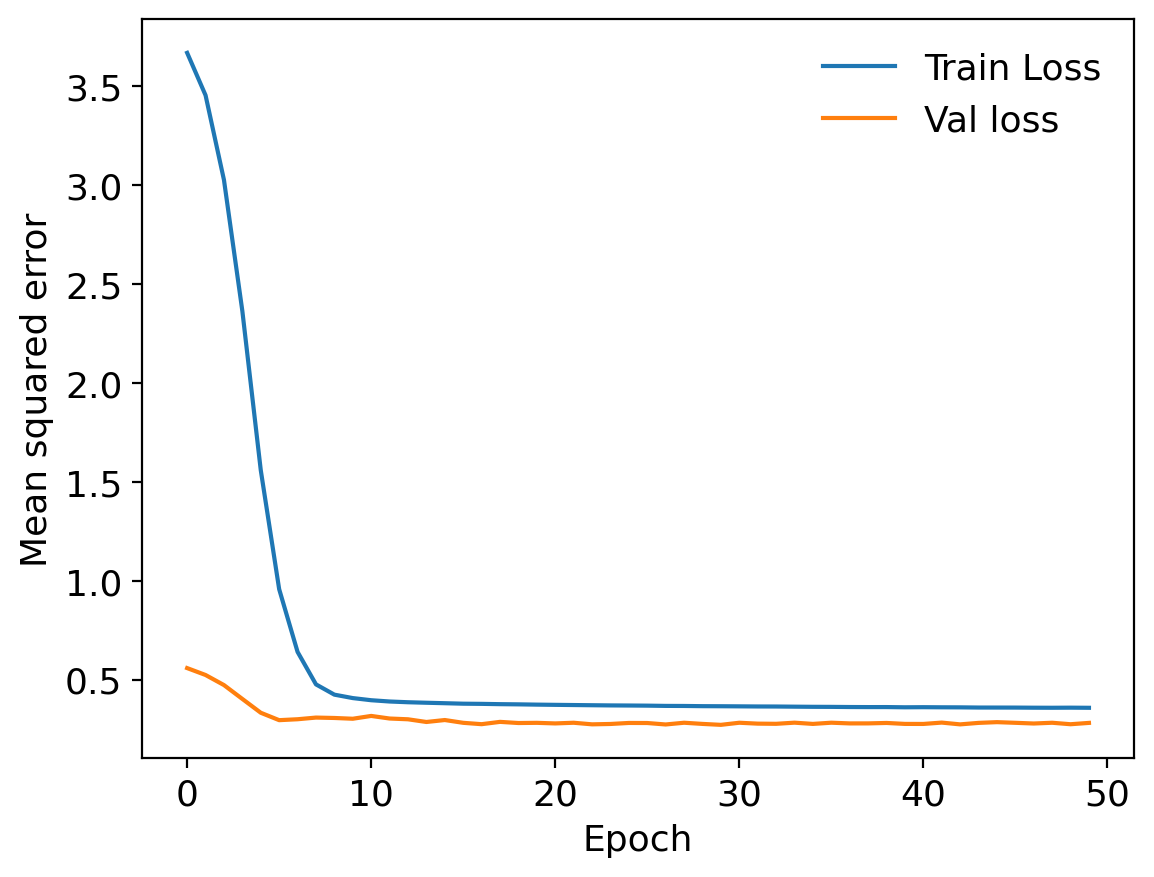

In [18]:
plot_history(history)

we can save the trained model as the `.h5` file.

In [19]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [20]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'NN_model.h5'))

### 4. Evaluate the trained model

Now let's evaluate the trained NN on the test set, by comparing the NN predictions against the tas originally simulated under the ssp245 scenario. 

In [21]:
# reload the saved model
model = load_model(os.path.join(model_path,'NN_model.h5'))

In [22]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

3/3 [==============================] - 0s 3ms/step


First we check whether the ML model can capture the spatial distribution of global temperature

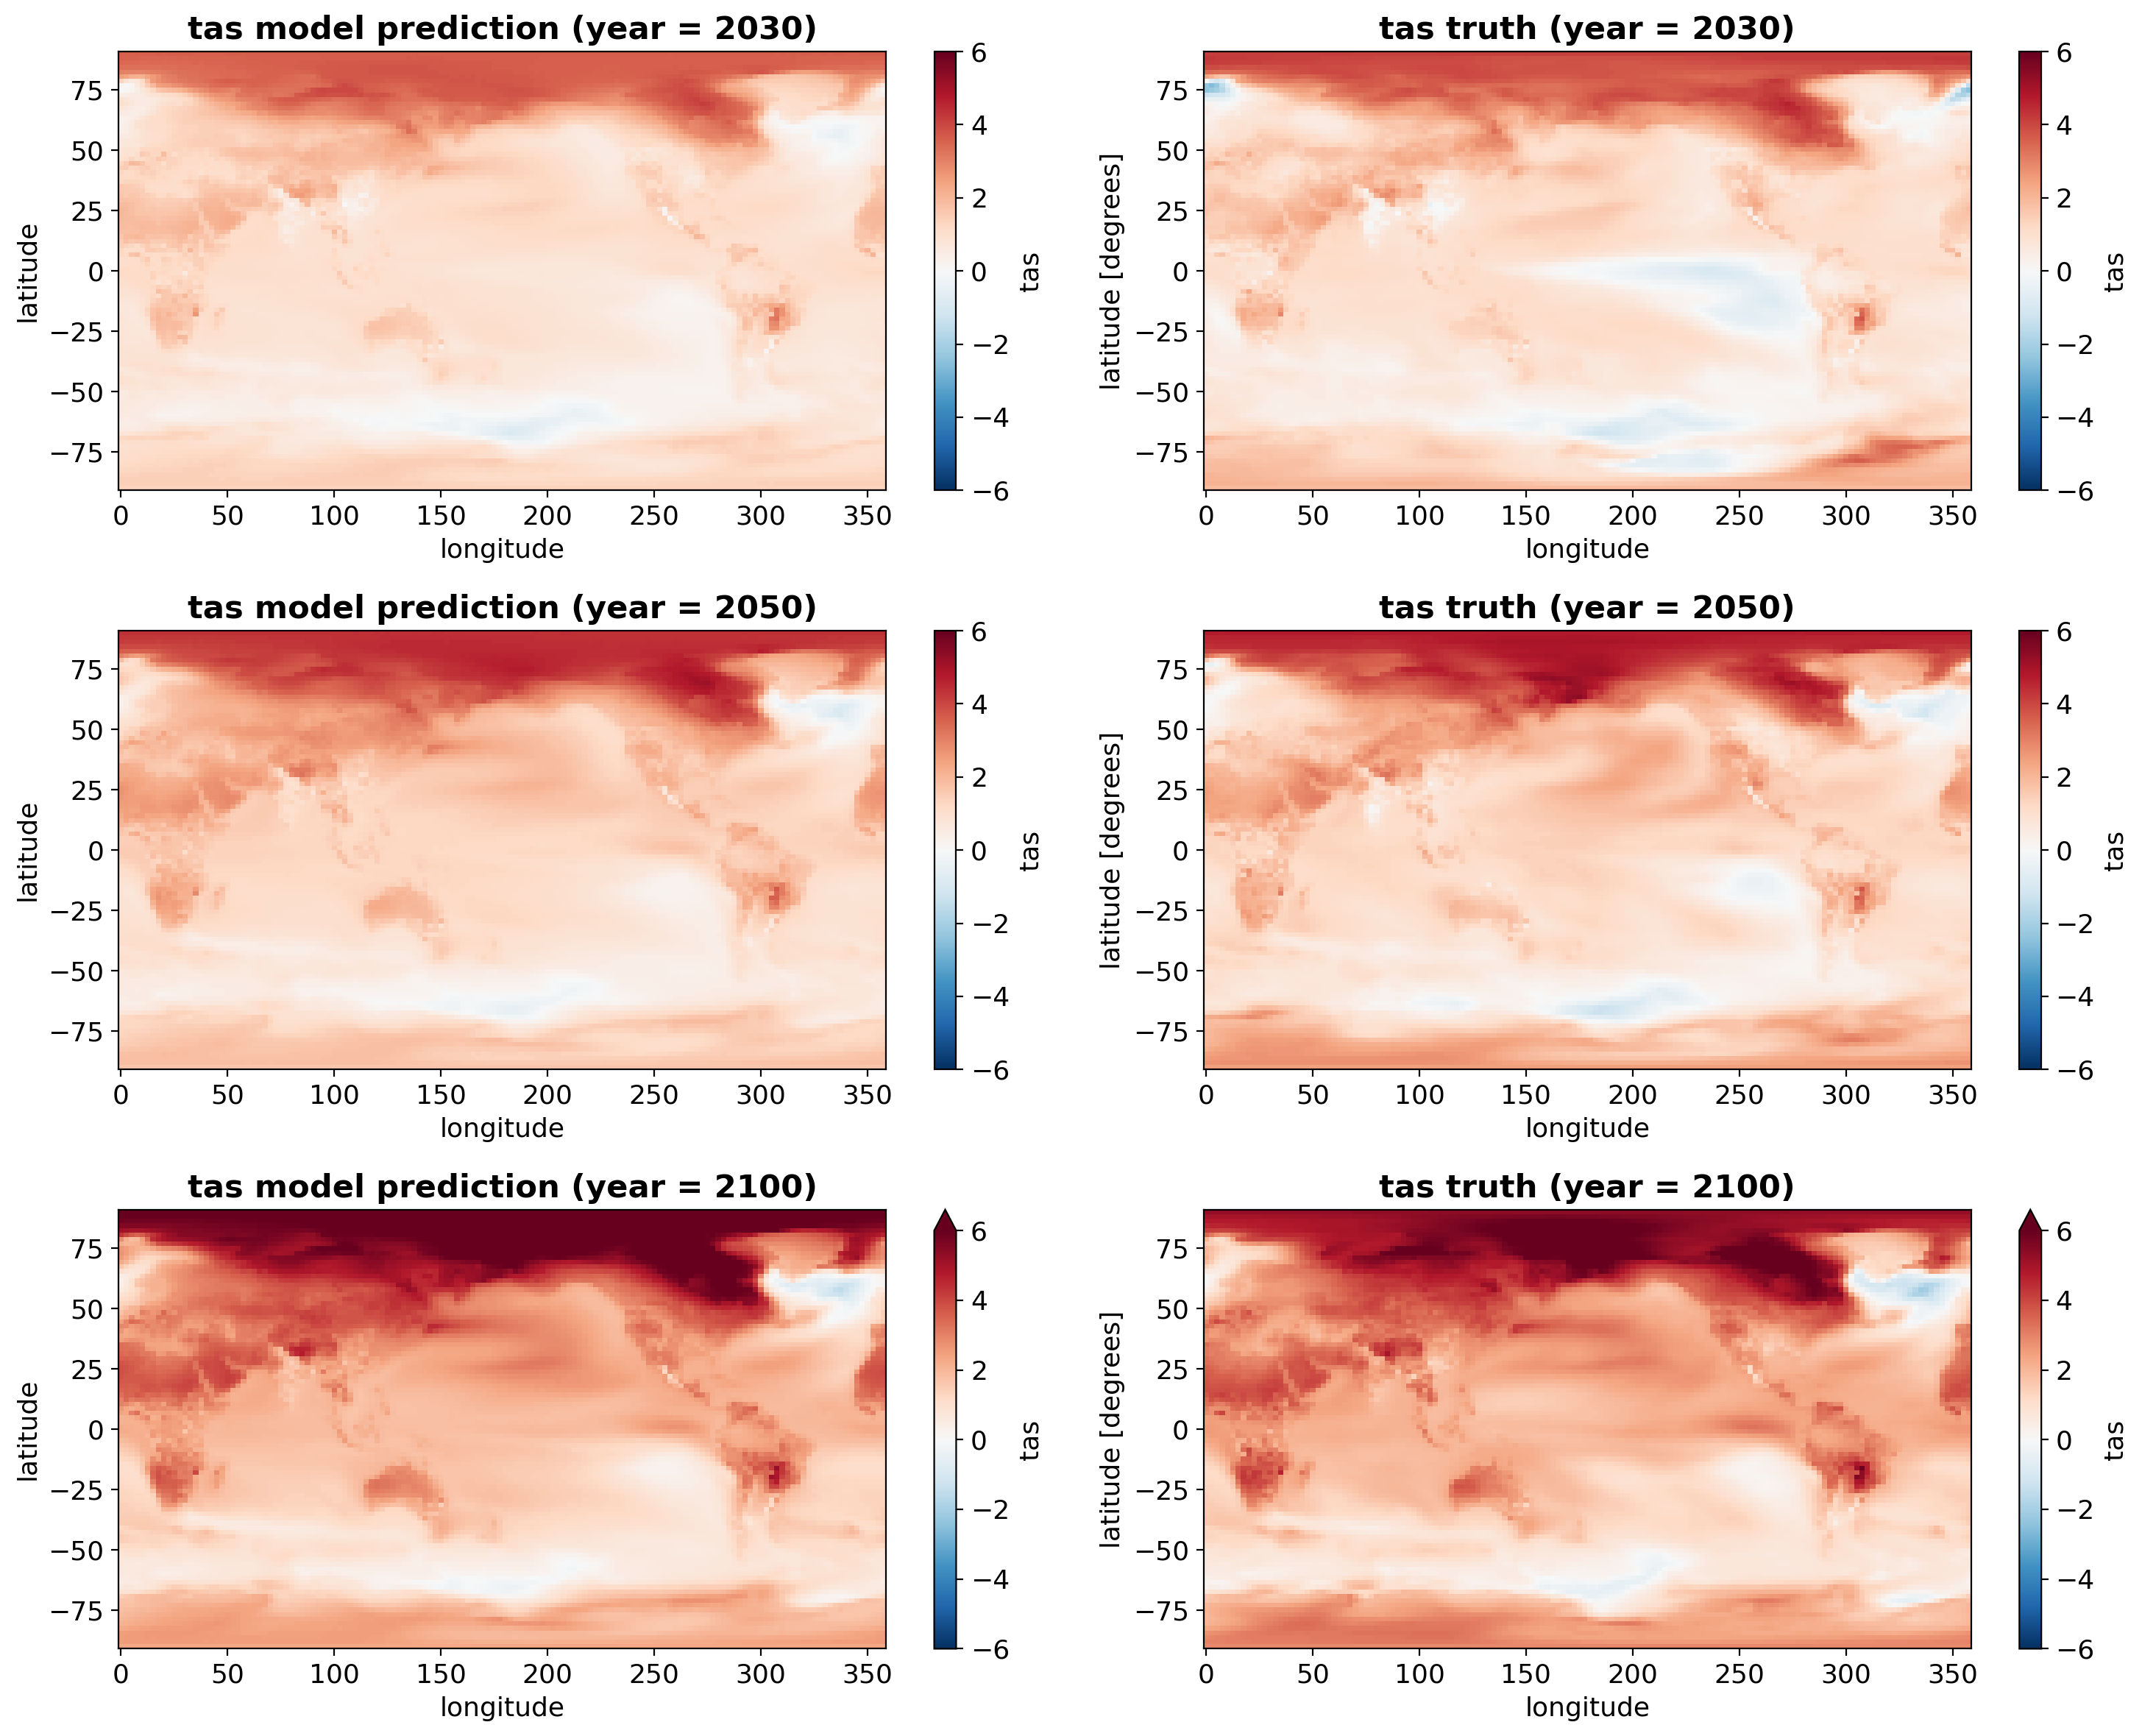

In [23]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

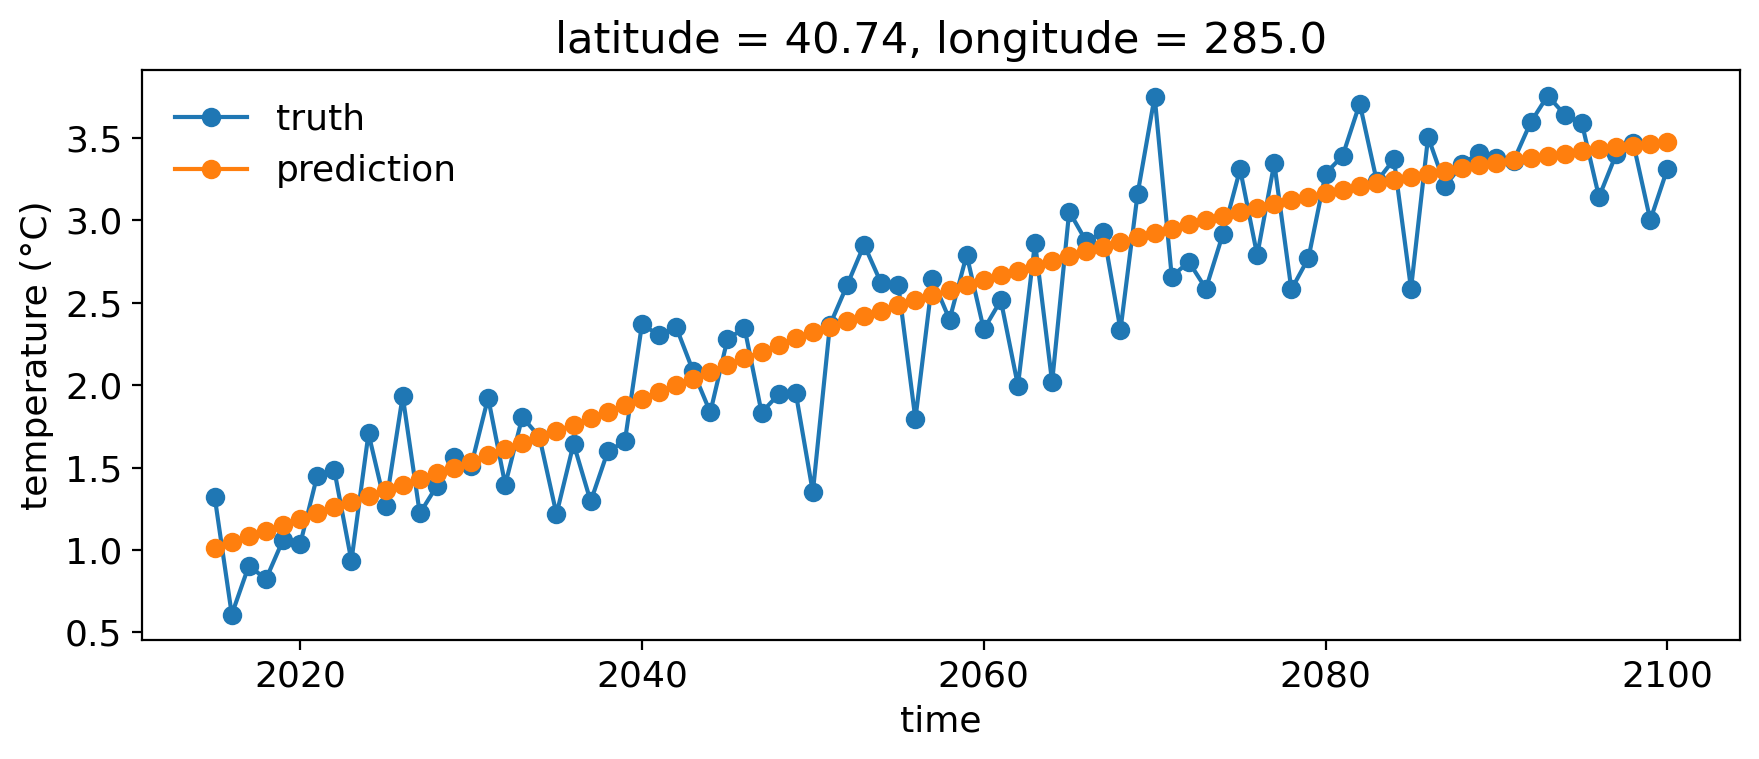

In [24]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction')

ax.legend()
ax.set_ylabel('temperature (°C)')

plt.tight_layout()

Let's check the statistical comparison between truth and prediction.

In [36]:
# combine truth and prediction arrays into a dataframe
nyc_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.values
nyc_test_pre = y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values

df_nyc_test = pd.DataFrame()
df_nyc_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_nyc_test["truth"] = nyc_test_xr
df_nyc_test["prediction"] = nyc_test_pre
print(df_nyc_test.head(10))

# summary statistics of the dataframe
df_nyc_test.describe()

   time     truth  prediction
0  2015  1.321960    1.009198
1  2016  0.608693    1.045923
2  2017  0.905599    1.082515
3  2018  0.822795    1.117983
4  2019  1.061228    1.153621
5  2020  1.035349    1.189595
6  2021  1.451701    1.225592
7  2022  1.484253    1.260312
8  2023  0.934296    1.293990
9  2024  1.707011    1.327689


,time,truth,prediction
count,86.000000,86.000000,86.000000
mean,2057.500000,2.395548,2.439099
std,24.969982,0.836997,0.767785
min,2015.000000,0.608693,1.009198
25%,2036.250000,1.691455,1.771096
50%,2057.500000,2.456390,2.559764
75%,2078.750000,3.155296,3.137805
max,2100.000000,3.757050,3.475836


Finally we check whether the ML model can capture the time series of global average temperature 

In [26]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

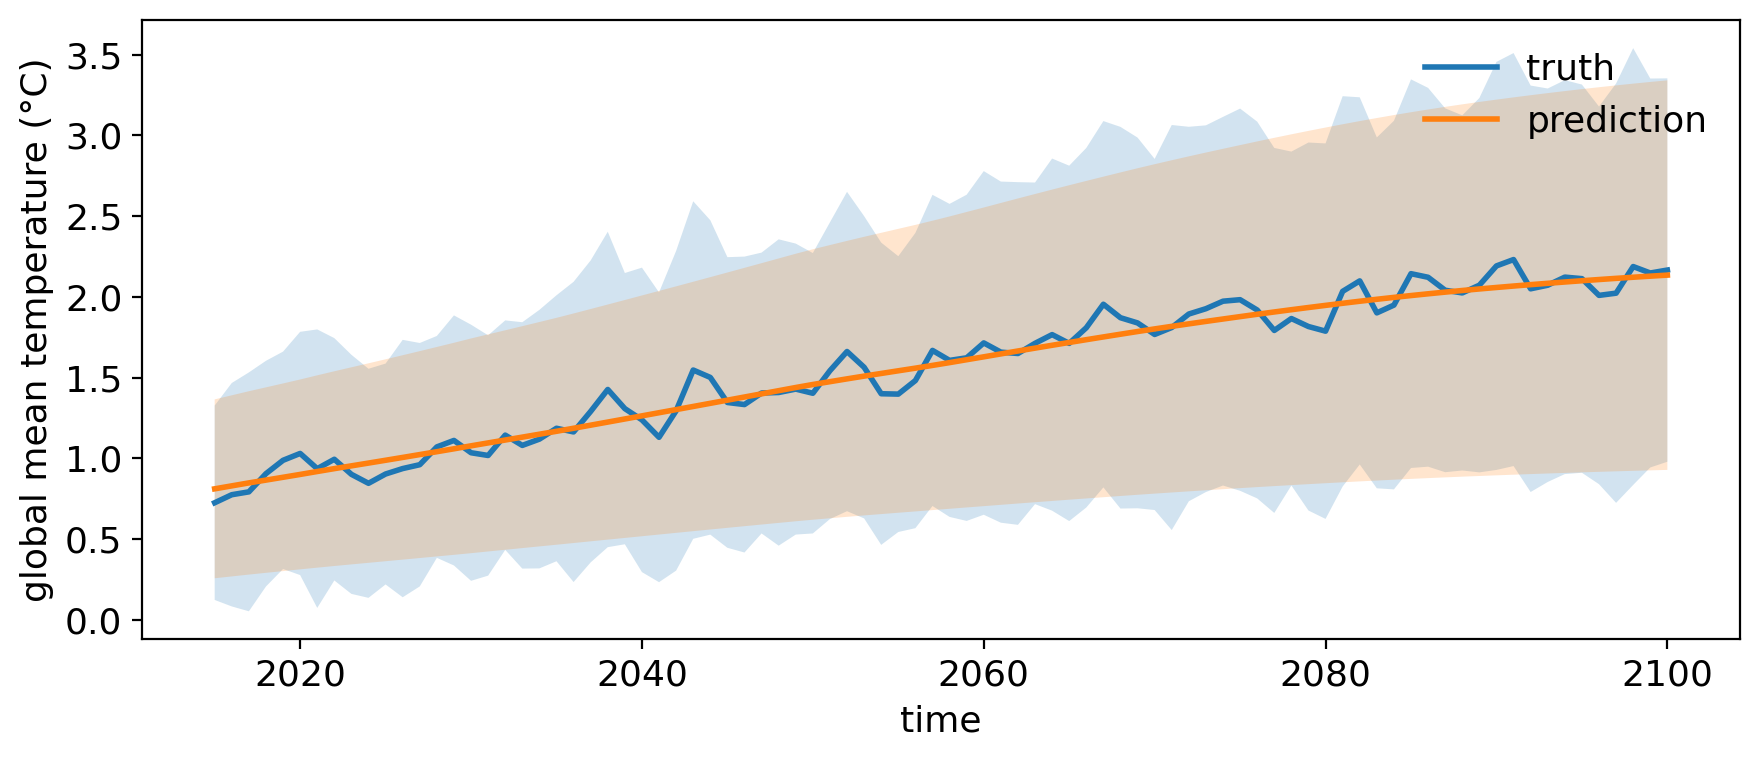

In [27]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_pre,label='prediction',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
ax.legend()
plt.tight_layout()

In [37]:
# get global mean temperature
def global_mean(X,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X['tas'].weighted(weights).mean(['latitude', 'longitude']).data
    return tas_mean

tas_mean_xr = global_mean(y_test_xr)
tas_mean_pre = global_mean(y_test_pre)

# put into dataframe
df_globalmean_test = pd.DataFrame()
df_globalmean_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_globalmean_test["truth"] = tas_mean_xr
df_globalmean_test["prediction"] = tas_mean_pre
print(df_globalmean_test.head(10))

# summary statistics of the dataframe
df_globalmean_test.describe()

   time     truth  prediction
0  2015  0.724876    0.811100
1  2016  0.774634    0.829476
2  2017  0.792321    0.847758
3  2018  0.905029    0.865192
4  2019  0.987700    0.882626
5  2020  1.030206    0.900225
6  2021  0.935918    0.918401
7  2022  0.994084    0.936128
8  2023  0.900831    0.953361
9  2024  0.845252    0.970604


,time,truth,prediction
count,86.000000,86.000000,86.000000
mean,2057.500000,1.564246,1.550268
std,24.969982,0.430099,0.411958
min,2015.000000,0.724876,0.811100
25%,2036.250000,1.169074,1.190963
50%,2057.500000,1.635698,1.583984
75%,2078.750000,1.943204,1.930391
max,2100.000000,2.230782,2.134406
